<a href="https://colab.research.google.com/github/jsdysw/face-GAN/blob/master/face-gan-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data loader에 방해가 되는 .ipynb_checkpoints 파일 제거

In [287]:
!rm -R img_align_celeba/.ipynb_checkpoints
!ls img_align_celeba/ -a   #to make sure that the deletion has occurred

rm: cannot remove 'img_align_celeba/.ipynb_checkpoints': No such file or directory
.  ..  img_align_celeba


Import Library

In [288]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from PIL import Image
from IPython.display import display
import cv2


import glob
import os
import random
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [289]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

파일 경로 정의, img_align_celebra/img_align_celebra 처럼 이중으로 되어있어야 함.

In [290]:
# Let's define the path
data_dir = 'img_align_celeba/'
# data_dir = '../input/celeba-dataset/img_align_celeba/'

In [291]:
# defining the image transform rules
'''
The augmentions are as follows, 
1. Resizing the image to 32x32 as the smaller the image the faster we can train 
2. Cropping from center with 32x32
3. Chagning type to tensor
we won't be using normalize here as we will have to do that manually later for tanh activation function
'''

transform_img = transforms.Compose([
        transforms.Resize(32),  
        transforms.CenterCrop(32),
        transforms.ToTensor()
    ])

DataLoader 정의

In [292]:
def get_dataloader(batch_size, data_dir, transforms):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param data_dir: Directory where image data is located
    :param transforms: data augmentations
    :return: DataLoader with batched data
    """
    
    ds = datasets.ImageFolder(data_dir, transform_img)
    data_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size,num_workers= 4, shuffle=True)

    return data_loader

In [293]:
batch_size = 32 # Instead of individual samples, the data loader produces batched samples of given number
train_loader = get_dataloader(batch_size,data_dir, transform_img)

총 데이터 수

In [294]:
print(len(train_loader.dataset))


4821


학습 데이터 출력

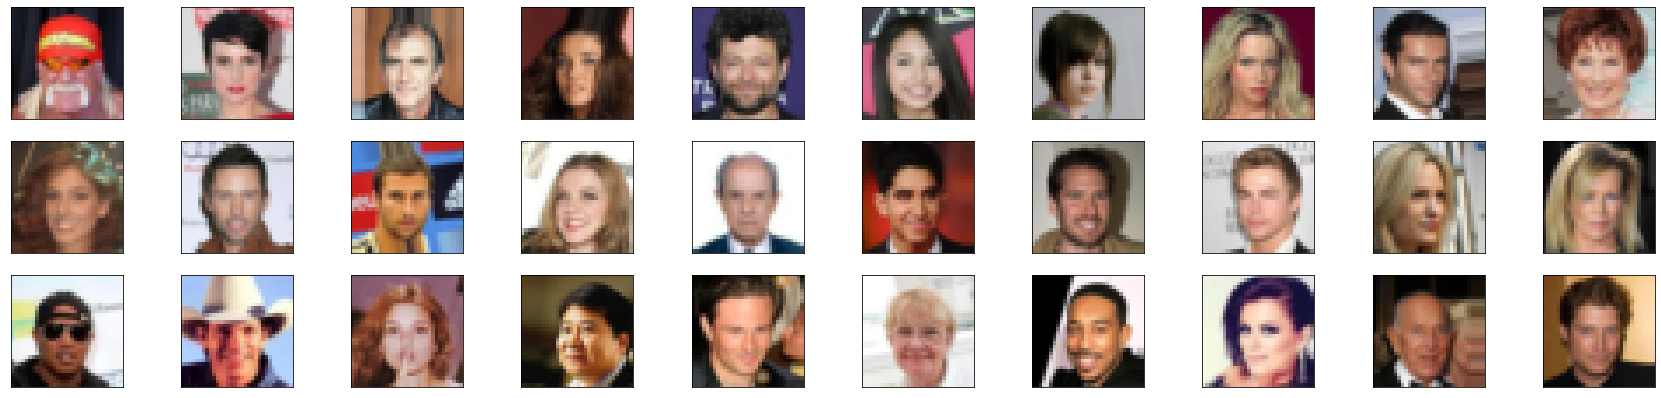

In [295]:
# Let's see if the train loader is working and sending us iterable images :) 
# Also note that we converted images to tensor above with ToTensor(). Now we need to convert back to numpy to plot them

# obtain one batch of training images which means 32 images
dataiter = iter(train_loader)
img, _ = dataiter.next() # _ for labels, Dataloader sends labels automatically as defined in Dataloader class.
#However we don't need labels neither we assigned one :p so we put _ 
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(30, 7))
plot_size=30 # gonna plot 30 images only
for idx in np.arange(plot_size):
    ax = fig.add_subplot(3, plot_size/3, idx+1, xticks=[], yticks=[])
    npimg = img[idx].numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Now we need to scale our images as the output of a tanh activated generator will contain pixel values in a range from -1 to 1. So, we need to rescale our training images to a range of -1 to 1.

In [296]:
def scale_images(x, max = 1.00 , min = -1.00):
    x = x * (max - min) + min
    return x

In [297]:
#let's check the scaling
img = img[5]
print('Before scaling min: ', img.min())
print('Before scaling max: ', img.max())

scaled_img = scale_images(img)

print('After Scaling Min: ', scaled_img.min())
print('After Scaling Max: ', scaled_img.max())

Before scaling min:  tensor(0.0353)
Before scaling max:  tensor(0.9020)
After Scaling Min:  tensor(-0.9294)
After Scaling Max:  tensor(0.8039)


In [298]:
'''
The inputs to the discriminator are 32x32x3 tensor images
The output would be a single value that will indicate whether a given image is real or fake
'''
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, bias = False):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding)
    #appending convolutional layer
    layers.append(conv_layer)
    #appending batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [299]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initializing the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer based on which we will create the  next ones where next  layer depth = 2 * previous layer depth
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        
        self.conv1 = conv(3, conv_dim, batch_norm=False)  
        self.conv2 = conv(conv_dim, conv_dim*2)           
        self.conv3 = conv(conv_dim*2, conv_dim*4)
        self.conv4 = conv(conv_dim*4, conv_dim*8)
        self.fc = nn.Linear(conv_dim*4*4*2, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        x = x.view(-1, self.conv_dim*4*2*4)
        
        x = self.fc(x)
        
        
        return x

In [300]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, bias = False):
    layers = []
    
    # append transpose conv layer -- we are not using bias terms in conv layers
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))
    
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [301]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        # complete init function
        
        self.de_conv1 = deconv(conv_dim*4, conv_dim*2)
        self.de_conv2 = deconv(conv_dim*2, conv_dim)
        self.de_conv3 = deconv(conv_dim, 3, 4, batch_norm=False )
        
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = self.dropout(x)
        
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.de_conv1(x))
        x = F.relu(self.de_conv2(x))
        x = self.de_conv3(x)
        x = F.tanh(x)
        
        
        return x

In [302]:
#Initializing the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.

def weights_init_normal(m):
    """
    :param m: A module or layer in a network    
    """
    # like `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    #  initial weights to convolutional and linear layers
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal(m.weight.data, 0.0, 0.2)
        
    if hasattr(m, 'bias') and m.bias is not None:
        nn.init.constant(m.bias.data, 0.0)

In [303]:
# model hyperparameters
d_conv_dim = 64
g_conv_dim = 128
z_size = 100
# building discriminator and generator from the classes defined above
discriminator = Discriminator(d_conv_dim)
generator = Generator(z_size=z_size, conv_dim=g_conv_dim)

# initialize model weights
discriminator.apply(weights_init_normal)
generator.apply(weights_init_normal)
print("done")

done


In [304]:
# let's look at our discriminator model
print(discriminator)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)


In [305]:
# let's look at our generator model
print(generator)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (de_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv3): Sequential(
    (0): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (dropout): Dropout(p=0.3, inplace=False)
)


In [306]:
use_gpu = torch.cuda.is_available()


In [307]:
lr = 0.0002 #learning rate
beta1=0.5
beta2=0.999

# optimizers for the discriminator D and generator G
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr, (beta1, beta2)) # for discriminator
generator_optimizer = torch.optim.Adam(generator.parameters(), lr, (beta1, beta2)) # for generator

In [308]:
def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
    
    if use_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if use_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [309]:
def train(D, G, n_epochs, train_on_gpu, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(train_loader):

            batch_size = real_images.size(0)
            real_images = scale_images(real_images)

            # Train the discriminator on real and fake images
            discriminator_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            discriminator_optimizer.step()     

            # 2. Train the generator with an adversarial loss
            generator_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
            D_fake = D(fake_images)
            
            g_loss = real_loss(D_fake)
        
            g_loss.backward()
            generator_optimizer.step()
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [310]:
n_epochs = 10
losses = train(discriminator, generator, n_epochs=n_epochs, train_on_gpu = use_gpu)

Epoch [    1/   10] | d_loss: 6.2916 | g_loss: 2.7529
Epoch [    1/   10] | d_loss: 0.3883 | g_loss: 10.8687
Epoch [    1/   10] | d_loss: 0.1528 | g_loss: 10.4415
Epoch [    1/   10] | d_loss: 0.0047 | g_loss: 9.8916
Epoch [    2/   10] | d_loss: 0.0222 | g_loss: 12.0227
Epoch [    2/   10] | d_loss: 0.1921 | g_loss: 11.5891
Epoch [    2/   10] | d_loss: 0.0367 | g_loss: 12.2841
Epoch [    2/   10] | d_loss: 0.0003 | g_loss: 10.5906
Epoch [    3/   10] | d_loss: 0.0020 | g_loss: 12.4161
Epoch [    3/   10] | d_loss: 0.0055 | g_loss: 12.1721
Epoch [    3/   10] | d_loss: 0.0067 | g_loss: 11.4025
Epoch [    3/   10] | d_loss: 0.0015 | g_loss: 12.0086
Epoch [    4/   10] | d_loss: 0.0683 | g_loss: 12.8027
Epoch [    4/   10] | d_loss: 0.0018 | g_loss: 11.1184
Epoch [    4/   10] | d_loss: 0.0008 | g_loss: 11.9598
Epoch [    4/   10] | d_loss: 0.0001 | g_loss: 10.9661
Epoch [    5/   10] | d_loss: 0.0157 | g_loss: 11.7992
Epoch [    5/   10] | d_loss: 0.0025 | g_loss: 11.6654
Epoch [    5

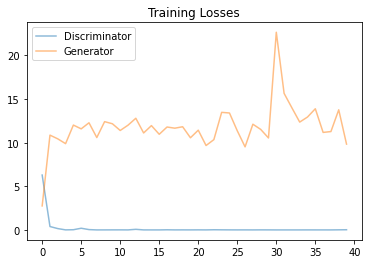

In [311]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [312]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [313]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

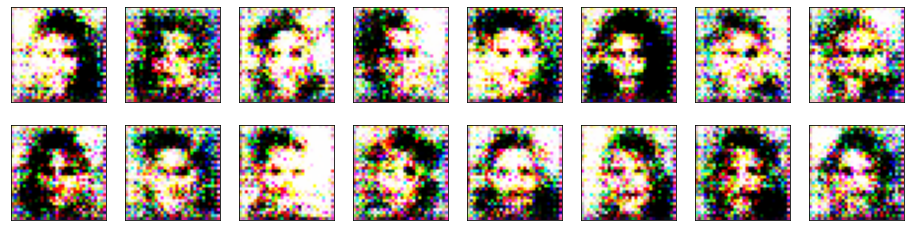

In [314]:
_ = view_samples(-1, samples)